# About

This notebook uses LLM to predict the risk category of the jobs when provided the skill vector (With combined skills)


In [2]:
from enum import Enum
import instructor
import pandas as pd
from openai import OpenAI
from pydantic import BaseModel, Field
import re

import instructor
from anthropic import Anthropic
import numpy as np

In [3]:
JOB_DESCRIPTION_PATH = '../onetonline_job_details'
INDUSTRY_DF_PATH = '../v2_assets/modified_bls_super_sector_df.csv'

LLM_JOBS_ANALYSIS_PATH = '../v2_assets/llm_risk.csv'

In [4]:
llm_risk_df = pd.read_csv(LLM_JOBS_ANALYSIS_PATH)
industry_df = pd.read_csv(INDUSTRY_DF_PATH)

In [5]:
# For software only automation

print(f'Risk - Software only - Min: {llm_risk_df["software_automation_risk"].min()}')
print(f'Risk - Software only - Max: {llm_risk_df["software_automation_risk"].max()}')

print(f'Risk - Software only - P50: {llm_risk_df["software_automation_risk"].quantile(0.5)}')
print(f'Risk - Software only - P25: {llm_risk_df["software_automation_risk"].quantile(0.25)}')
print(f'Risk - Software only - P75: {llm_risk_df["software_automation_risk"].quantile(0.75)}')

# For software + robotics automation
print(f'Risk - Software + robotics - Min: {llm_risk_df["software_and_robotics_automation_risk"].min()}')
print(f'Risk - Software + robotics - Max: {llm_risk_df["software_and_robotics_automation_risk"].max()}')

print(f'Risk - Software + robotics - P50: {llm_risk_df["software_and_robotics_automation_risk"].quantile(0.5)}')
print(f'Risk - Software + robotics - P25: {llm_risk_df["software_and_robotics_automation_risk"].quantile(0.25)}')
print(f'Risk - Software + robotics - P75: {llm_risk_df["software_and_robotics_automation_risk"].quantile(0.75)}')

# Adoption rate: Software only

print(f'Adoption rate - Software only - Min: {llm_risk_df["software_only_adoption_rate"].min()}')
print(f'Adoption rate - Software only - Max: {llm_risk_df["software_only_adoption_rate"].max()}')

print(f'Adoption rate - Software only - P50: {llm_risk_df["software_only_adoption_rate"].quantile(0.5)}')
print(f'Adoption rate - Software only - P25: {llm_risk_df["software_only_adoption_rate"].quantile(0.25)}')
print(f'Adoption rate - Software only - P75: {llm_risk_df["software_only_adoption_rate"].quantile(0.75)}')

# Adoption rate: Software + robotics
print(f'Adoption rate - Software + robotics - Min: {llm_risk_df["software_and_robotics_adoption_rate"].min()}')
print(f'Adoption rate - Software + robotics - Max: {llm_risk_df["software_and_robotics_adoption_rate"].max()}')

print(f'Adoption rate - Software + robotics - P50: {llm_risk_df["software_and_robotics_adoption_rate"].quantile(0.5)}')
print(f'Adoption rate - Software + robotics - P25: {llm_risk_df["software_and_robotics_adoption_rate"].quantile(0.25)}')
print(f'Adoption rate - Software + robotics - P75: {llm_risk_df["software_and_robotics_adoption_rate"].quantile(0.75)}')

Risk - Software only - Min: 1.0
Risk - Software only - Max: 9.0
Risk - Software only - P50: 4.0
Risk - Software only - P25: 3.0
Risk - Software only - P75: 4.0
Risk - Software + robotics - Min: 1.0
Risk - Software + robotics - Max: 9.0
Risk - Software + robotics - P50: 4.0
Risk - Software + robotics - P25: 2.0
Risk - Software + robotics - P75: 6.0
Adoption rate - Software only - Min: 2.0
Adoption rate - Software only - Max: 8.0
Adoption rate - Software only - P50: 5.0
Adoption rate - Software only - P25: 4.0
Adoption rate - Software only - P75: 6.0
Adoption rate - Software + robotics - Min: 1.0
Adoption rate - Software + robotics - Max: 8.0
Adoption rate - Software + robotics - P50: 4.0
Adoption rate - Software + robotics - P25: 3.0
Adoption rate - Software + robotics - P75: 5.0


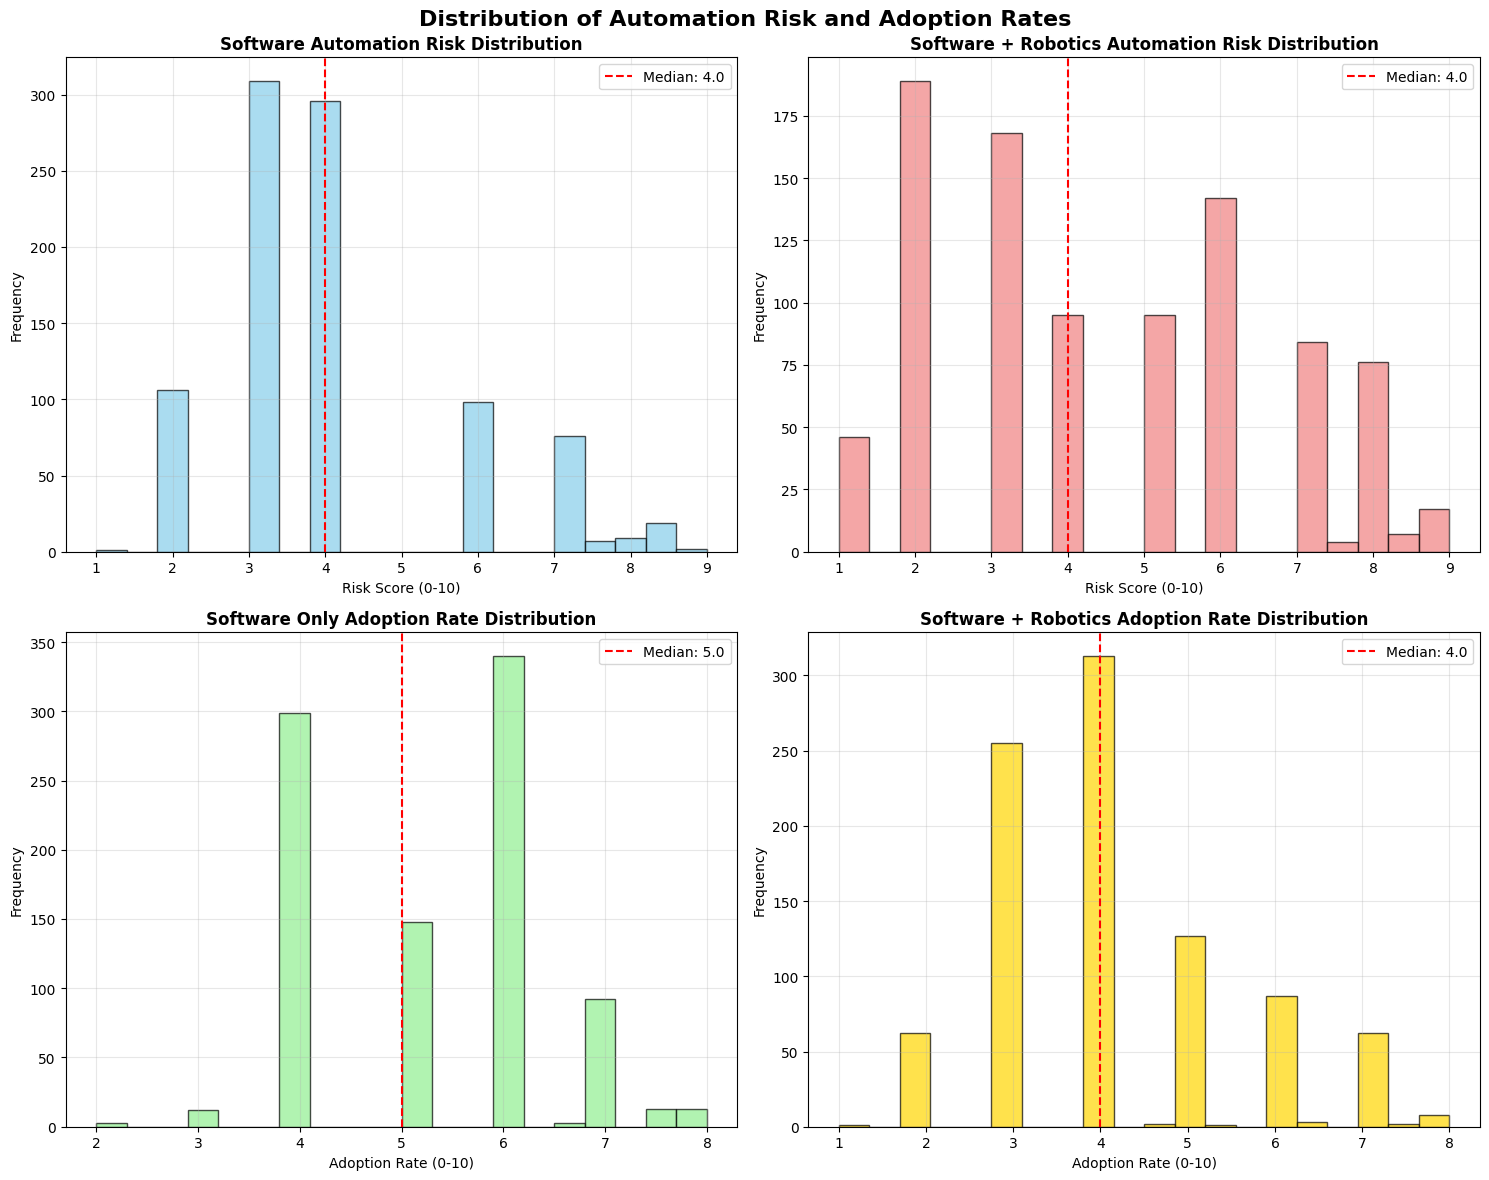

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a figure with subplots for all risk and adoption quantities
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Automation Risk and Adoption Rates', fontsize=16, fontweight='bold')

# Plot 1: Software Automation Risk
axes[0, 0].hist(llm_risk_df['software_automation_risk'].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Software Automation Risk Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Risk Score (0-10)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(llm_risk_df['software_automation_risk'].median(), color='red', linestyle='--', label=f'Median: {llm_risk_df["software_automation_risk"].median():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Software + Robotics Automation Risk
axes[0, 1].hist(llm_risk_df['software_and_robotics_automation_risk'].dropna(), bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Software + Robotics Automation Risk Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Risk Score (0-10)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(llm_risk_df['software_and_robotics_automation_risk'].median(), color='red', linestyle='--', label=f'Median: {llm_risk_df["software_and_robotics_automation_risk"].median():.1f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Software Only Adoption Rate
axes[1, 0].hist(llm_risk_df['software_only_adoption_rate'].dropna(), bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Software Only Adoption Rate Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Adoption Rate (0-10)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(llm_risk_df['software_only_adoption_rate'].median(), color='red', linestyle='--', label=f'Median: {llm_risk_df["software_only_adoption_rate"].median():.1f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Software + Robotics Adoption Rate
axes[1, 1].hist(llm_risk_df['software_and_robotics_adoption_rate'].dropna(), bins=20, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Software + Robotics Adoption Rate Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Adoption Rate (0-10)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(llm_risk_df['software_and_robotics_adoption_rate'].median(), color='red', linestyle='--', label=f'Median: {llm_risk_df["software_and_robotics_adoption_rate"].median():.1f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
import os
import glob
import json

def get_job_summary(file_path):
    """
    Read a JSON file and return the content of the 'summary' key.
    
    Args:
        file_path (str): Path to the JSON file
        
    Returns:
        str: Content of the 'summary' key, or None if not found
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            
        # Return the summary content
        summary = data.get('summary', None)
        
        if summary is None:
            print(f"Warning: 'summary' key not found in {file_path}")
            
        return summary
        
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON in {file_path} - {e}")
        return None
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

def create_complete_job_dataframe(job_description_path, include_summaries=True, sample_size=None):
    """
    Create a comprehensive DataFrame with O*NET-SOC Code, file path, and summary.
    
    Args:
        job_description_path (str): Path to the directory containing JSON files
        include_summaries (bool): Whether to extract and include job summaries
        sample_size (int, optional): Number of files to process. If None, processes all.
        
    Returns:
        pd.DataFrame: DataFrame with columns: O*NET-SOC Code, file_path, summary
    """
    def extract_job_title_regex(job_string):
        """
        Extract job title from O*NET-SOC formatted string using regex.
        
        Args:
            job_string (str): String in format "code - job title"
            
        Returns:
            str: The job title part, or original string if pattern doesn't match
        """
        # Pattern explanation:
        # ^[\d\-\.]+  - Start of string, one or more digits, hyphens, or dots
        # \s*-\s*     - Optional whitespace, hyphen, optional whitespace
        # (.+)$       - Capture group for everything else until end of string
        pattern = r'^[\d\-\.]+\s*-\s*(.+)$'
        
        match = re.match(pattern, job_string.strip())
        if match:
            return match.group(1).strip()
        return job_string

    # Get all JSON files in the directory
    json_files = glob.glob(os.path.join(job_description_path, "*.json"))
    
    if sample_size:
        json_files = json_files[:sample_size]
    
    data = []
    total_files = len(json_files)
    
    print(f"Processing {total_files} job description files...")
    
    for i, file_path in enumerate(json_files):
        # Get the filename without the path
        filename = os.path.basename(file_path)
        
        # Extract O*NET-SOC Code by splitting by '_' and getting the 0th element
        onet_soc_code = filename.split('_')[0]
        
        # Initialize row data
        row_data = {
            'O*NET-SOC Code': onet_soc_code,
            'file_path': file_path,
        }
        
        # Add summary if requested
        if include_summaries:
            summary = get_job_summary(file_path)
            title = summary.get('name', None)
            title = extract_job_title_regex(title)
            row_data['Title'] = title
            row_data['summary'] = summary
        
        data.append(row_data)
        
        # Progress indicator
        if (i + 1) % 50 == 0 or (i + 1) == total_files:
            print(f"Processed {i + 1}/{total_files} files")
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Sort by O*NET-SOC Code for better organization
    df = df.sort_values('O*NET-SOC Code').reset_index(drop=True)
    
    return df

# Create the complete DataFrame with all information
print("Creating complete job descriptions DataFrame with summaries...")
job_descriptions_df = create_complete_job_dataframe(JOB_DESCRIPTION_PATH, include_summaries=True)

print(f"\nDataFrame created successfully!")
print(f"Shape: {job_descriptions_df.shape}")
print(f"Columns: {list(job_descriptions_df.columns)}")

Creating complete job descriptions DataFrame with summaries...
Processing 923 job description files...
Processed 50/923 files
Processed 100/923 files
Processed 150/923 files
Processed 200/923 files
Processed 250/923 files
Processed 300/923 files
Processed 350/923 files
Processed 400/923 files
Processed 450/923 files
Processed 500/923 files
Processed 550/923 files
Processed 600/923 files
Processed 650/923 files
Processed 700/923 files
Processed 750/923 files
Processed 800/923 files
Processed 850/923 files
Processed 900/923 files
Processed 923/923 files

DataFrame created successfully!
Shape: (923, 4)
Columns: ['O*NET-SOC Code', 'file_path', 'Title', 'summary']


In [8]:
job_descriptions_df = job_descriptions_df.merge(industry_df[['O*NET-SOC Code', 'Modified BLS Super Sector']], on='O*NET-SOC Code', how='left')

In [9]:
job_descriptions_df

,O*NET-SOC Code,file_path,Title,summary,Modified BLS Super Sector
0,11-1011.00,../onetonline_job_details/11-1011.00_20250611_...,Chief Executives,"{'soc_code': '11-1011.00', 'name': '11-1011.00...",MANAGEMENT
1,11-1011.03,../onetonline_job_details/11-1011.03_20250611_...,Chief Sustainability Officers,"{'soc_code': '11-1011.03', 'name': '11-1011.03...",MANAGEMENT
2,11-1021.00,../onetonline_job_details/11-1021.00_20250611_...,General and Operations Managers,"{'soc_code': '11-1021.00', 'name': '11-1021.00...",MANAGEMENT
3,11-1031.00,../onetonline_job_details/11-1031.00_20250611_...,Legislators,"{'soc_code': '11-1031.00', 'name': '11-1031.00...",GOVERNMENT
4,11-2011.00,../onetonline_job_details/11-2011.00_20250611_...,Advertising and Promotions Managers,"{'soc_code': '11-2011.00', 'name': '11-2011.00...",MEDIA_AND_COMMUNICATIONS_SERVICES
...,...,...,...,...,...
918,53-7071.00,../onetonline_job_details/53-7071.00_20250611_...,Gas Compressor and Gas Pumping Station Operators,"{'soc_code': '53-7071.00', 'name': '53-7071.00...",ENERGY
919,53-7072.00,../onetonline_job_details/53-7072.00_20250611_...,"Pump Operators, Except Wellhead Pumpers","{'soc_code': '53-7072.00', 'name': '53-7072.00...",MANUFACTURING
920,53-7073.00,../onetonline_job_details/53-7073.00_20250611_...,Wellhead Pumpers,"{'soc_code': '53-7073.00', 'name': '53-7073.00...",MINING_OIL_GAS_EXTRACTION
921,53-7081.00,../onetonline_job_details/53-7081.00_20250611_...,Refuse and Recyclable Material Collectors,"{'soc_code': '53-7081.00', 'name': '53-7081.00...",SPECIAL_INDUSTRIES


In [10]:
system_prompt = """
You are an expert labour economist bot that reasons and thinks about the future prospects of a job role.

You have access to some premises extracted from a well established WEF's Future of Jobs Report 2025 to
predict the risk of automation for a given occupation. Utilize the premises to predict the risk of automation for a given occupation.

Following are the premises that you will be using to predict the risk of automation for a given occupation:

Short Term / Software only Automation:

| Vulnerable Duties                                                                                                                                           | Safe Duties                                                                                                                                       |
| ----------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Templated data entry**<br>\[“Data Entry Clerks –24 net growth”; “Bank Tellers and Related Clerks –20 net growth”]                                         | **Framing strategy & designing novel solutions**<br>\[“Analytical thinking 88 %”; “Creative thinking 62 %”]                                       |
| **Rule‑based admin workflows**<br>\[“Administrative Assistants and Executive Secretaries –18 net growth”; “Legal Secretaries –?” (among fastest‑declining)] | **Tackling ambiguous problems without clear precedents**<br>\[“Resilience, flexibility and agility 75 %”; “Curiosity and lifelong learning 81 %”] |
| **Metric‑driven, routine reporting**<br>\[“Accountants and Auditors –8 net growth”; “Claims Adjusters, Examiners, and Investigators” among declines]        | **Deep domain & experiential expertise**<br>\[“Leadership and social influence 88 %”; “Motivation and self‑awareness 58 %”]                       |
| **Standardized correspondence generation**<br>\[“Legal Secretaries” in top‑declining list; “Postal Service Clerks”]                                         | **High‑stakes ethical/legal judgment**<br>\[“Empathy and active listening 81 %”; “Service orientation and customer service” stable core skill]    |
| **Meeting narrow accuracy targets**<br>\[“Claims Adjusters, Examiners, and Investigators”]; \[“Cashiers and Ticket Clerks”]                                 | **Building relationships & coaching**<br>\[“Teaching and mentoring”; “Leadership and social influence 88 %”]                                      |


Long Term / Software+Robotics Automation:

| Vulnerable Duties                                                                                                                | Safe Duties                                                                                                                        |
| -------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| **Repetitive assembly tasks**<br>\[“Assembly and Factory Workers –4 net growth”; “Printing and Related Trades Workers”]          | **Fine‑motor craftsmanship**<br>\[“Manual dexterity, endurance and precision”; “Drafters, Engineering and Mapping Technicians”]    |
| **Bulk handling & fixed workflows**<br>\[“Material‑Recording and Stock‑Keeping Clerks”; “Door‑To‑Door Sales Workers”]            | **Adaptability in variable environments**<br>\[“Resilience, flexibility and agility 75 %”; “Curiosity and lifelong learning 81 %”] |
| **Operating standardized machinery**<br>\[“Printing and Related Trades Workers”; “Transportation Attendants and Conductors”]     | **Human‑centric care & education**<br>\[“Empathy and active listening 81 %”; “Service orientation and customer service”]           |
| **Uniform load‑lifting**<br>\[“Construction Labourers” in declining roles; “Cashiers and Ticket Clerks” handle repetitive loads] | **On‑the‑fly physical problem solving**<br>\[“Curiosity and lifelong learning 81 %”; “Systems thinking”]                           |
| **Exact blueprint adherence**<br>\[“Building Framers, Finishers, and Related Trades Workers”]                                    | **Creative physical expression**<br>\[“Creative thinking 69 %”; “Motivation and self‑awareness 58 %”]                              |


You will be given job title and some job attributes that show the work activies that are done by the employees in that job.
You will also be given the largest industry that the job belongs to.

With all the job context and the premises, you will be able to predict the risk of automation for a given occupation for both
1. Short Term / Software Automation scenario
2. Long Term / Robotics Automation scenario
"""

In [11]:
from tenacity import Retrying, stop_after_attempt, wait_fixed

client = instructor.from_anthropic(Anthropic())

class SoftwareAutomationRisk(BaseModel):
    risk_score: float = Field(description="The risk score for the job between 0 and 10; score <= 2 is low risk, score >= 8 is high risk; score 3-7 is medium risk")
    risk_explanation: str = Field(description="Brief explanation (< 150 tokens) of the automation risks score considering when AI capabilities ONLY in the software are reliably available in the industry")

class SoftwareAndRoboticsAutomationRisk(BaseModel):
    risk_score: float = Field(description="The risk score for the job between 0 and 10; score <= 2 is low risk, score >= 8 is high risk; score 3-7 is medium risk")
    risk_explanation: str = Field(description="Brief explanation (< 150 tokens) of the automation risks score considering when AI capabilities in the software and robotics are reliably available in the industry.")

class AutomationAdoptionRate(BaseModel):
    software_only_adoption_rate: float = Field(description="Considering the job and the largest industry it belongs to, output the software only automation adoption rate of automation in the industry - between 0 and 10; rate <= 2 is slow adoption, score >= 8 is quick adoption; score 3-7 is average speed adoption")
    software_and_robotics_adoption_rate: float = Field(description="Considering the job and the largest industry it belongs to, output the software + robotics automation adoption rate of automation in the industry - between 0 and 10; rate <= 2 is slow adoption, score >= 8 is quick adoption; score 3-7 is average speed adoption")
    adoption_rate_explanation: str = Field(description="Brief explanation (< 150 tokens) of you gave the adoption rate for software only and software + robotics automation, reason using how fast the industry is to accept the changes in general. For example, training individuals or setting up systems at scale could be costly causing the adoption to be slow etc.")

class AutomationRiskOutput(BaseModel):
    software_automation_risk: SoftwareAutomationRisk
    software_and_robotics_automation_risk: SoftwareAndRoboticsAutomationRisk
    automation_adoption_rate: AutomationAdoptionRate

In [ ]:
def get_automation_risk(job_title, job_description, job_industry) -> AutomationRiskOutput:
    query = f"""
    Job title: {job_title}
    Job description: {job_description}
    Job industry: {job_industry}
    """
    return client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {"role": "user", "content": query},
        ],
        model="claude-sonnet-4-20250514",
        max_tokens=2048,
        temperature=0.0,
        response_model=AutomationRiskOutput,
            max_retries=Retrying(
            stop=stop_after_attempt(2),  
            wait=wait_fixed(30),  
        )
    )

In [12]:
from concurrent.futures import ThreadPoolExecutor

def process_job_row(row_data):
    """Process a single job row and return the results"""
    index, row = row_data
    
    try:
        automation_risk = get_automation_risk(row['Title'], row['summary'], row['Modified BLS Super Sector'])
        
        return {
            'index': index,
            'software_automation_risk': automation_risk.software_automation_risk.risk_score,
            'software_automation_reason': automation_risk.software_automation_risk.risk_explanation,
            'software_and_robotics_automation_risk': automation_risk.software_and_robotics_automation_risk.risk_score,
            'software_and_robotics_automation_reason': automation_risk.software_and_robotics_automation_risk.risk_explanation,
            'software_only_adoption_rate': automation_risk.automation_adoption_rate.software_only_adoption_rate,
            'software_and_robotics_adoption_rate': automation_risk.automation_adoption_rate.software_and_robotics_adoption_rate,
            'automation_adoption_rate_reason': automation_risk.automation_adoption_rate.adoption_rate_explanation
        }
    except Exception as e:
        print(f"Error processing job {row['Title']}: {e}")
        return {
            'index': index,
            'software_automation_risk': np.nan,
            'software_automation_reason': '',
            'software_and_robotics_automation_risk': np.nan,
            'software_and_robotics_automation_reason': '',
            'software_only_adoption_rate': np.nan,
            'software_and_robotics_adoption_rate': np.nan,
            'automation_adoption_rate_reason': ''
        }

In [22]:
# job_descriptions_df['software_automation_risk'] = np.nan
# job_descriptions_df['software_automation_reason'] = ''
# job_descriptions_df['software_and_robotics_automation_risk'] = np.nan
# job_descriptions_df['software_and_robotics_automation_reason'] = ''

# job_descriptions_df['software_only_adoption_rate'] = np.nan
# job_descriptions_df['software_and_robotics_adoption_rate'] = np.nan
# job_descriptions_df['automation_adoption_rate_reason'] = ''

# # Parallelize the processing
# # sample_df = job_descriptions_df.sample(n=9)
# sample_df = job_descriptions_df

# # Prepare data for parallel processing
# row_data = list(sample_df.iterrows())

# print(f"Processing {len(row_data)} jobs with 5 concurrent threads...")

# # Process jobs in parallel with concurrency 5
# with ThreadPoolExecutor(max_workers=5) as executor:
#     results = list(executor.map(process_job_row, row_data))

# print("Updating DataFrame with results...")

# # Update the DataFrame with results
# for result in results:
#     if result:  # Check if result is not None
#         index = result['index']
#         sample_df.at[index, 'software_automation_risk'] = result['software_automation_risk']
#         sample_df.at[index, 'software_automation_reason'] = result['software_automation_reason']
#         sample_df.at[index, 'software_and_robotics_automation_risk'] = result['software_and_robotics_automation_risk']
#         sample_df.at[index, 'software_and_robotics_automation_reason'] = result['software_and_robotics_automation_reason']
#         sample_df.at[index, 'software_only_adoption_rate'] = result['software_only_adoption_rate']
#         sample_df.at[index, 'software_and_robotics_adoption_rate'] = result['software_and_robotics_adoption_rate']
#         sample_df.at[index, 'automation_adoption_rate_reason'] = result['automation_adoption_rate_reason']

# print("Processing completed!")

Processing 923 jobs with 5 concurrent threads...
Updating DataFrame with results...
Processing completed!


In [23]:
# sample_df = sample_df.drop(['file_path', 'summary'], axis=1)

# Calibration

In [12]:
# Enhanced scoring system with quartile-based calibration

def calculate_quartiles_and_examples(df, score_column):
    """Calculate quartiles and select representative examples for each quartile"""
    # Remove any NaN values
    clean_df = df.dropna(subset=[score_column])
    
    # Calculate quartiles
    q1 = clean_df[score_column].quantile(0.25)
    q2 = clean_df[score_column].quantile(0.50)  # median
    q3 = clean_df[score_column].quantile(0.75)
    
    # Select representative examples from each quartile
    q1_examples = clean_df[clean_df[score_column] <= q1].sample(n=min(3, len(clean_df[clean_df[score_column] <= q1])), random_state=42)
    q2_examples = clean_df[(clean_df[score_column] > q1) & (clean_df[score_column] <= q3)].sample(n=min(3, len(clean_df[(clean_df[score_column] > q1) & (clean_df[score_column] <= q3)])), random_state=42)
    q3_examples = clean_df[clean_df[score_column] >= q3].sample(n=min(3, len(clean_df[clean_df[score_column] >= q3])), random_state=42)
    
    return {
        'quartiles': {'q1': q1, 'q2': q2, 'q3': q3},
        'examples': {
            'q1': q1_examples,
            'q2': q2_examples, 
            'q3': q3_examples
        }
    }

def create_calibration_prompt(quartile_data, score_type):
    """Create calibration section for the prompt"""
    q1_examples = quartile_data['examples']['q1']
    q2_examples = quartile_data['examples']['q2']
    q3_examples = quartile_data['examples']['q3']
    
    quartiles = quartile_data['quartiles']
    
    prompt_section = f"""
## Calibration Examples for {score_type}

To help you provide accurate scores, here are examples from our existing dataset:

### LOW RISK (Scores ≤ {quartiles['q1']:.1f} - First Quartile):
"""
    
    for _, row in q1_examples.iterrows():
        score_col = 'software_automation_risk' if 'software' in score_type.lower() else 'software_and_robotics_automation_risk'
        reason_col = score_col.replace('risk', 'reason')
        prompt_section += f"- **{row['Title']}** (Score: {row[score_col]:.1f}): {row[reason_col][:100]}...\n"
    
    prompt_section += f"""
### MEDIUM RISK (Scores {quartiles['q1']:.1f} - {quartiles['q3']:.1f} - Second/Third Quartile):
"""
    
    for _, row in q2_examples.iterrows():
        score_col = 'software_automation_risk' if 'software' in score_type.lower() else 'software_and_robotics_automation_risk'
        reason_col = score_col.replace('risk', 'reason')
        prompt_section += f"- **{row['Title']}** (Score: {row[score_col]:.1f}): {row[reason_col][:100]}...\n"
    
    prompt_section += f"""
### HIGH RISK (Scores ≥ {quartiles['q3']:.1f} - Fourth Quartile):
"""
    
    for _, row in q3_examples.iterrows():
        score_col = 'software_automation_risk' if 'software' in score_type.lower() else 'software_and_robotics_automation_risk'
        reason_col = score_col.replace('risk', 'reason')
        prompt_section += f"- **{row['Title']}** (Score: {row[score_col]:.1f}): {row[reason_col][:100]}...\n"
    
    prompt_section += f"""
Please use these examples as reference points to ensure your scoring is consistent with the established scale.
The median score in our dataset is {quartiles['q2']:.1f}.
"""
    
    return prompt_section


In [18]:
# Load existing scores to calculate quartiles
existing_scores_df = pd.read_csv(LLM_JOBS_ANALYSIS_PATH)

existing_scores_df = existing_scores_df.merge(job_descriptions_df[['O*NET-SOC Code', 'summary']], on='O*NET-SOC Code', how='left')

In [19]:

# Calculate quartiles for both software and software+robotics scores
software_quartiles = calculate_quartiles_and_examples(existing_scores_df, 'software_automation_risk')
robotics_quartiles = calculate_quartiles_and_examples(existing_scores_df, 'software_and_robotics_automation_risk')

print("Software Automation Risk Quartiles:")
print(f"Q1: {software_quartiles['quartiles']['q1']:.2f}")
print(f"Q2 (Median): {software_quartiles['quartiles']['q2']:.2f}")
print(f"Q3: {software_quartiles['quartiles']['q3']:.2f}")

print("\nSoftware + Robotics Automation Risk Quartiles:")
print(f"Q1: {robotics_quartiles['quartiles']['q1']:.2f}")
print(f"Q2 (Median): {robotics_quartiles['quartiles']['q2']:.2f}")
print(f"Q3: {robotics_quartiles['quartiles']['q3']:.2f}")


Software Automation Risk Quartiles:
Q1: 3.00
Q2 (Median): 4.00
Q3: 4.00

Software + Robotics Automation Risk Quartiles:
Q1: 2.00
Q2 (Median): 4.00
Q3: 6.00


In [ ]:
# Enhanced system prompt with calibration examples
def create_enhanced_system_prompt(software_quartiles, robotics_quartiles):
    base_prompt = """
You are an expert labour economist bot that reasons and thinks about the future prospects of a job role.

You have access to some premises extracted from a well established WEF's Future of Jobs Report 2025 to
predict the risk of automation for a given occupation. 

!Important:
- You previously predicted the risk of automation for a given occupation in isolation of that specific job.
- Now, you will have access to sample of your prior predictions for precise calibration.
- For calibration each job, you will be supplied some samples of your prior predictions from different quartiles of the risk of automation for a given occupation.


Again, like the last time - all your prediction should be backed by the premises from the WEF's Future of Jobs Report 2025.
Following are the premises that you will be using to predict the risk of automation for a given occupation:

Short Term / Software only Automation:

| Vulnerable Duties                                                                                                                                           | Safe Duties                                                                                                                                       |
| ----------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Templated data entry**<br>["Data Entry Clerks –24 net growth"; "Bank Tellers and Related Clerks –20 net growth"]                                         | **Framing strategy & designing novel solutions**<br>["Analytical thinking 88 %"; "Creative thinking 62 %"]                                       |
| **Rule‑based admin workflows**<br>["Administrative Assistants and Executive Secretaries –18 net growth"; "Legal Secretaries –?" (among fastest‑declining)] | **Tackling ambiguous problems without clear precedents**<br>["Resilience, flexibility and agility 75 %"; "Curiosity and lifelong learning 81 %"] |
| **Metric‑driven, routine reporting**<br>["Accountants and Auditors –8 net growth"; "Claims Adjusters, Examiners, and Investigators" among declines]        | **Deep domain & experiential expertise**<br>["Leadership and social influence 88 %"; "Motivation and self‑awareness 58 %"]                       |
| **Standardized correspondence generation**<br>["Legal Secretaries" in top‑declining list; "Postal Service Clerks"]                                         | **High‑stakes ethical/legal judgment**<br>["Empathy and active listening 81 %"; "Service orientation and customer service" stable core skill]    |
| **Meeting narrow accuracy targets**<br>["Claims Adjusters, Examiners, and Investigators"]; ["Cashiers and Ticket Clerks"]                                 | **Building relationships & coaching**<br>["Teaching and mentoring"; "Leadership and social influence 88 %"]                                      |


Long Term / Software+Robotics Automation:

| Vulnerable Duties                                                                                                                | Safe Duties                                                                                                                        |
| -------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| **Repetitive assembly tasks**<br>["Assembly and Factory Workers –4 net growth"; "Printing and Related Trades Workers"]          | **Fine‑motor craftsmanship**<br>["Manual dexterity, endurance and precision"; "Drafters, Engineering and Mapping Technicians"]    |
| **Bulk handling & fixed workflows**<br>["Material‑Recording and Stock‑Keeping Clerks"; "Door‑To‑Door Sales Workers"]            | **Adaptability in variable environments**<br>["Resilience, flexibility and agility 75 %"; "Curiosity and lifelong learning 81 %"] |
| **Operating standardized machinery**<br>["Printing and Related Trades Workers"; "Transportation Attendants and Conductors"]     | **Human‑centric care & education**<br>["Empathy and active listening 81 %"; "Service orientation and customer service"]           |
| **Uniform load‑lifting**<br>["Construction Labourers" in declining roles; "Cashiers and Ticket Clerks" handle repetitive loads] | **On‑the‑fly physical problem solving**<br>["Curiosity and lifelong learning 81 %"; "Systems thinking"]                           |
| **Exact blueprint adherence**<br>["Building Framers, Finishers, and Related Trades Workers"]                                    | **Creative physical expression**<br>["Creative thinking 69 %"; "Motivation and self‑awareness 58 %"]                              |

"""
    
    # Add calibration examples
    software_calibration = create_calibration_prompt(software_quartiles, "Software Automation Risk")
    robotics_calibration = create_calibration_prompt(robotics_quartiles, "Software + Robotics Automation Risk")
    
    enhanced_prompt = base_prompt + software_calibration + robotics_calibration + """

You will be given job title and some job attributes that show the work activities that are done by the employees in that job.
You will also be given the largest industry that the job belongs to.

With all the job context, the premises, and the calibration examples above, you will be able to predict the risk of automation for a given occupation for both:
1. Short Term / Software Automation scenario
2. Long Term / Robotics Automation scenario

IMPORTANT: Use the calibration examples as reference points to ensure your scoring is consistent with the established scale. Pay attention to the quartile boundaries and typical score ranges.
"""
    
    return enhanced_prompt

# Create the enhanced system prompt
enhanced_system_prompt = create_enhanced_system_prompt(software_quartiles, robotics_quartiles)


In [ ]:
# Enhanced automation risk function with calibration
def get_enhanced_automation_risk(job_title, job_description, job_industry) -> AutomationRiskOutput:
    query = f"""
    Job title: {job_title}
    Job description: {job_description}
    Job industry: {job_industry}
    """
    return client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": enhanced_system_prompt,
            },
            {"role": "user", "content": query},
        ],
        model="claude-sonnet-4-20250514",
        max_tokens=2048,
        temperature=0.0,
        response_model=AutomationRiskOutput,
        max_retries=Retrying(
            stop=stop_after_attempt(2),  
            wait=wait_fixed(30),  
        )
    )

def process_job_row_enhanced(row_data):
    """Process a single job row using enhanced calibrated scoring"""
    index, row = row_data
    
    try:
        automation_risk = get_enhanced_automation_risk(row['Title'], row['summary'], row['Modified BLS Super Sector'])
        
        return {
            'index': index,
            'software_automation_risk_enhanced': automation_risk.software_automation_risk.risk_score,
            'software_automation_reason_enhanced': automation_risk.software_automation_risk.risk_explanation,
            'software_and_robotics_automation_risk_enhanced': automation_risk.software_and_robotics_automation_risk.risk_score,
            'software_and_robotics_automation_reason_enhanced': automation_risk.software_and_robotics_automation_risk.risk_explanation,
            'software_only_adoption_rate_enhanced': automation_risk.automation_adoption_rate.software_only_adoption_rate,
            'software_and_robotics_adoption_rate_enhanced': automation_risk.automation_adoption_rate.software_and_robotics_adoption_rate,
            'automation_adoption_rate_reason_enhanced': automation_risk.automation_adoption_rate.adoption_rate_explanation
        }
    except Exception as e:
        print(f"Error processing job {row['Title']}: {e}")
        return {
            'index': index,
            'software_automation_risk_enhanced': np.nan,
            'software_automation_reason_enhanced': '',
            'software_and_robotics_automation_risk_enhanced': np.nan,
            'software_and_robotics_automation_reason_enhanced': '',
            'software_only_adoption_rate_enhanced': np.nan,
            'software_and_robotics_adoption_rate_enhanced': np.nan,
            'automation_adoption_rate_reason_enhanced': ''
        }


In [ ]:
# Test the enhanced scoring on a small sample first
print("Testing enhanced scoring on a sample of 10 jobs...")

# Select a sample for testing
test_sample = job_descriptions_df.sample(n=10, random_state=42)

# Add enhanced columns to track new scores
test_sample = test_sample.copy()
test_sample['software_automation_risk_enhanced'] = np.nan
test_sample['software_automation_reason_enhanced'] = ''
test_sample['software_and_robotics_automation_risk_enhanced'] = np.nan
test_sample['software_and_robotics_automation_reason_enhanced'] = ''
test_sample['software_only_adoption_rate_enhanced'] = np.nan
test_sample['software_and_robotics_adoption_rate_enhanced'] = np.nan
test_sample['automation_adoption_rate_reason_enhanced'] = ''

# Process the test sample
row_data = list(test_sample.iterrows())

print(f"Processing {len(row_data)} test jobs with enhanced scoring...")

with ThreadPoolExecutor(max_workers=3) as executor:
    results = list(executor.map(process_job_row_enhanced, row_data))

# Update test sample with results
for result in results:
    if result:
        index = result['index']
        test_sample.at[index, 'software_automation_risk_enhanced'] = result['software_automation_risk_enhanced']
        test_sample.at[index, 'software_automation_reason_enhanced'] = result['software_automation_reason_enhanced']
        test_sample.at[index, 'software_and_robotics_automation_risk_enhanced'] = result['software_and_robotics_automation_risk_enhanced']
        test_sample.at[index, 'software_and_robotics_automation_reason_enhanced'] = result['software_and_robotics_automation_reason_enhanced']
        test_sample.at[index, 'software_only_adoption_rate_enhanced'] = result['software_only_adoption_rate_enhanced']
        test_sample.at[index, 'software_and_robotics_adoption_rate_enhanced'] = result['software_and_robotics_adoption_rate_enhanced']
        test_sample.at[index, 'automation_adoption_rate_reason_enhanced'] = result['automation_adoption_rate_reason_enhanced']

print("Test processing completed!")


In [ ]:
# Optional: Run enhanced scoring for all jobs
# Uncomment the following block to run the enhanced scoring for all 923 jobs
# WARNING: This will take considerable time and API costs

run_full_enhanced_scoring = False  # Set to True to run full dataset

if run_full_enhanced_scoring:
    print("Running enhanced scoring for all 923 jobs...")
    
    # Prepare the full dataset
    full_enhanced_df = job_descriptions_df.copy()
    full_enhanced_df['software_automation_risk_enhanced'] = np.nan
    full_enhanced_df['software_automation_reason_enhanced'] = ''
    full_enhanced_df['software_and_robotics_automation_risk_enhanced'] = np.nan
    full_enhanced_df['software_and_robotics_automation_reason_enhanced'] = ''
    full_enhanced_df['software_only_adoption_rate_enhanced'] = np.nan
    full_enhanced_df['software_and_robotics_adoption_rate_enhanced'] = np.nan
    full_enhanced_df['automation_adoption_rate_reason_enhanced'] = ''
    
    # Process all jobs
    row_data = list(full_enhanced_df.iterrows())
    
    print(f"Processing {len(row_data)} jobs with 5 concurrent threads...")
    
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(process_job_row_enhanced, row_data))
    
    print("Updating DataFrame with enhanced results...")
    
    # Update the DataFrame with enhanced results
    for result in results:
        if result:
            index = result['index']
            full_enhanced_df.at[index, 'software_automation_risk_enhanced'] = result['software_automation_risk_enhanced']
            full_enhanced_df.at[index, 'software_automation_reason_enhanced'] = result['software_automation_reason_enhanced']
            full_enhanced_df.at[index, 'software_and_robotics_automation_risk_enhanced'] = result['software_and_robotics_automation_risk_enhanced']
            full_enhanced_df.at[index, 'software_and_robotics_automation_reason_enhanced'] = result['software_and_robotics_automation_reason_enhanced']
            full_enhanced_df.at[index, 'software_only_adoption_rate_enhanced'] = result['software_only_adoption_rate_enhanced']
            full_enhanced_df.at[index, 'software_and_robotics_adoption_rate_enhanced'] = result['software_and_robotics_adoption_rate_enhanced']
            full_enhanced_df.at[index, 'automation_adoption_rate_reason_enhanced'] = result['automation_adoption_rate_reason_enhanced']
    
    # Save the enhanced results
    enhanced_output_path = '../v2_assets/llm_risk_enhanced.csv'
    full_enhanced_df.drop(['file_path', 'summary'], axis=1).to_csv(enhanced_output_path, index=False)
    print(f"Enhanced results saved to {enhanced_output_path}")
    
    print("Full enhanced processing completed!")
else:
    print("Set run_full_enhanced_scoring = True to run enhanced scoring for all jobs")
    print("For now, you can examine the test sample results above to evaluate the improvement.")


In [ ]:
# Compare original vs enhanced scores for the test sample
comparison_columns = ['Title', 'Modified BLS Super Sector', 
                     'software_automation_risk', 'software_automation_risk_enhanced',
                     'software_and_robotics_automation_risk', 'software_and_robotics_automation_risk_enhanced']

# Merge original scores with test sample for comparison
if 'software_automation_risk' not in test_sample.columns:
    test_sample = test_sample.merge(existing_scores_df[['O*NET-SOC Code', 'software_automation_risk', 'software_and_robotics_automation_risk']], 
                                   on='O*NET-SOC Code', how='left')

print("Comparison of Original vs Enhanced Scores:")
print("=" * 80)
for _, row in test_sample.iterrows():
    print(f"\n**{row['Title']}** ({row['Modified BLS Super Sector']})")
    print(f"Software Risk: {row['software_automation_risk']:.1f} → {row['software_automation_risk_enhanced']:.1f} (Δ: {row['software_automation_risk_enhanced'] - row['software_automation_risk']:+.1f})")
    print(f"Software+Robotics Risk: {row['software_and_robotics_automation_risk']:.1f} → {row['software_and_robotics_automation_risk_enhanced']:.1f} (Δ: {row['software_and_robotics_automation_risk_enhanced'] - row['software_and_robotics_automation_risk']:+.1f})")
    print(f"Enhanced Reasoning (Software): {row['software_automation_reason_enhanced'][:100]}...")

print("\n" + "=" * 80)
print("Summary Statistics:")
print(f"Software Risk - Mean Change: {(test_sample['software_automation_risk_enhanced'] - test_sample['software_automation_risk']).mean():.2f}")
print(f"Software Risk - Std of Changes: {(test_sample['software_automation_risk_enhanced'] - test_sample['software_automation_risk']).std():.2f}")
print(f"Software+Robotics Risk - Mean Change: {(test_sample['software_and_robotics_automation_risk_enhanced'] - test_sample['software_and_robotics_automation_risk']).mean():.2f}")
print(f"Software+Robotics Risk - Std of Changes: {(test_sample['software_and_robotics_automation_risk_enhanced'] - test_sample['software_and_robotics_automation_risk']).std():.2f}")


In [31]:
# sample_df.to_csv(LLM_JOBS_ANALYSIS_PATH, index=False)